In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix


In [38]:
# Check if MPS is available for M1 GPU acceleration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [39]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST mean and std
])

# Load MNIST datasets
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into train and validation sets (50000 train, 10000 validation)
train_size = 50000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [40]:
# Define LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # First convolutional layer: 1 input channel, 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Initialize the model, loss function, and optimizer
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [41]:
def count_parameters(model):
    """Count the total number of trainable parameters in the model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Print parameters by layer
    print("Model Parameters Summary:")
    print("-" * 60)
    print(f"{'Layer':<30} {'Shape':<20} {'Parameters':<10}")
    print("-" * 60)
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:<30} {str(list(param.shape)):<20} {param.numel():<10}")
    
    print("-" * 60)
    print(f"Total Trainable Parameters: {trainable_params:,}")
    print(f"Total Parameters: {total_params:,}")
    
    return trainable_params

# Count parameters in the model
param_count = count_parameters(model)


Model Parameters Summary:
------------------------------------------------------------
Layer                          Shape                Parameters
------------------------------------------------------------
conv1.weight                   [6, 1, 5, 5]         150       
conv1.bias                     [6]                  6         
conv2.weight                   [16, 6, 5, 5]        2400      
conv2.bias                     [16]                 16        
fc1.weight                     [120, 400]           48000     
fc1.bias                       [120]                120       
fc2.weight                     [84, 120]            10080     
fc2.bias                       [84]                 84        
fc3.weight                     [10, 84]             840       
fc3.bias                       [10]                 10        
------------------------------------------------------------
Total Trainable Parameters: 61,706
Total Parameters: 61,706


In [42]:
# Lists to store metrics for plotting
train_accuracies = []
test_accuracies = []
epoch_losses = []

# Training function
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create a tqdm progress bar for the current epoch
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update running loss and progress bar
        running_loss += loss.item()
        pbar.set_postfix({'loss': running_loss/len(pbar), 'accuracy': 100.*correct/total})
    
    # Calculate final metrics for the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    
    return train_loss, train_accuracy

# Validation function
def validate(loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(loader)
    val_accuracy = 100. * correct / total
    return val_accuracy, avg_val_loss



In [43]:
# Function to plot training results
def plot_results(train_acc, val_acc, train_loss, val_loss, epochs):
    epochs_range = list(range(1, epochs + 1))
    
    plt.figure(figsize=(15, 5))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('lenet_mnist_accuracy_loss.png')
    plt.show()



In [44]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Starting training...


Epoch 1: 100%|██████████| 782/782 [00:08<00:00, 89.19it/s, loss=0.307, accuracy=90.2] 


Epoch 1 completed:
 - Training loss: 0.3067, Validation loss: 0.0891
 - Training accuracy: 90.19%, Validation accuracy: 97.18%
 - Time: 11.23 seconds
--------------------------------------------------


Epoch 2: 100%|██████████| 782/782 [00:09<00:00, 86.47it/s, loss=0.0709, accuracy=97.8] 


Epoch 2 completed:
 - Training loss: 0.0709, Validation loss: 0.0646
 - Training accuracy: 97.83%, Validation accuracy: 97.84%
 - Time: 11.58 seconds
--------------------------------------------------


Epoch 3: 100%|██████████| 782/782 [00:08<00:00, 89.64it/s, loss=0.0513, accuracy=98.4]  


Epoch 3 completed:
 - Training loss: 0.0513, Validation loss: 0.0574
 - Training accuracy: 98.40%, Validation accuracy: 98.31%
 - Time: 11.66 seconds
--------------------------------------------------


Epoch 4: 100%|██████████| 782/782 [00:08<00:00, 87.38it/s, loss=0.0399, accuracy=98.7]  


Epoch 4 completed:
 - Training loss: 0.0399, Validation loss: 0.0613
 - Training accuracy: 98.75%, Validation accuracy: 98.16%
 - Time: 11.40 seconds
--------------------------------------------------


Epoch 5: 100%|██████████| 782/782 [00:09<00:00, 81.30it/s, loss=0.0332, accuracy=99]    


Epoch 5 completed:
 - Training loss: 0.0332, Validation loss: 0.0507
 - Training accuracy: 98.97%, Validation accuracy: 98.50%
 - Time: 12.96 seconds
--------------------------------------------------


Epoch 6: 100%|██████████| 782/782 [00:10<00:00, 72.14it/s, loss=0.0284, accuracy=99.1] 


Epoch 6 completed:
 - Training loss: 0.0284, Validation loss: 0.0497
 - Training accuracy: 99.08%, Validation accuracy: 98.69%
 - Time: 13.65 seconds
--------------------------------------------------


Epoch 7: 100%|██████████| 782/782 [00:09<00:00, 83.57it/s, loss=0.0239, accuracy=99.2]  


Epoch 7 completed:
 - Training loss: 0.0239, Validation loss: 0.0458
 - Training accuracy: 99.18%, Validation accuracy: 98.62%
 - Time: 12.40 seconds
--------------------------------------------------


Epoch 8: 100%|██████████| 782/782 [00:08<00:00, 92.68it/s, loss=0.0202, accuracy=99.4]  


Epoch 8 completed:
 - Training loss: 0.0202, Validation loss: 0.0473
 - Training accuracy: 99.36%, Validation accuracy: 98.59%
 - Time: 10.75 seconds
--------------------------------------------------


Epoch 9: 100%|██████████| 782/782 [00:08<00:00, 92.75it/s, loss=0.0178, accuracy=99.4]  


Epoch 9 completed:
 - Training loss: 0.0178, Validation loss: 0.0489
 - Training accuracy: 99.41%, Validation accuracy: 98.68%
 - Time: 10.85 seconds
--------------------------------------------------


Epoch 10: 100%|██████████| 782/782 [00:08<00:00, 91.42it/s, loss=0.0154, accuracy=99.5]  


Epoch 10 completed:
 - Training loss: 0.0154, Validation loss: 0.0508
 - Training accuracy: 99.53%, Validation accuracy: 98.89%
 - Time: 11.05 seconds
--------------------------------------------------

Training Summary:
Total Training Time: 117.52 seconds
Average Time per Epoch: 11.75 seconds
Total Wall Clock Time (including validation): 117.53 seconds


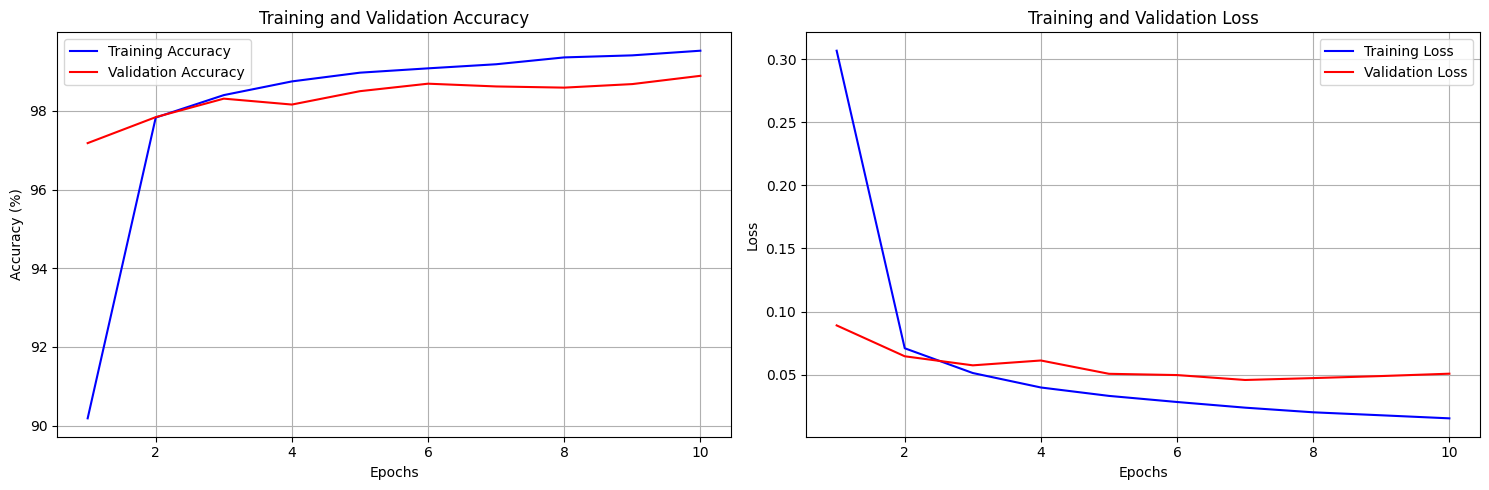

In [45]:
# Train the model
num_epochs = 10
print("Starting training...")

# Lists to store metrics for plotting
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# For timing measurements
total_training_time = 0
epoch_times = []
overall_start_time = time.time()

for epoch in range(num_epochs):
    # Start timing this epoch
    epoch_start_time = time.time()
    
    # Train for one epoch and get metrics
    train_loss, train_accuracy = train(epoch)
    
    # Validate the model on validation set (not test set)
    val_accuracy, val_loss = validate(val_loader)
    
    # Store metrics for plotting
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Calculate time taken for this epoch
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    total_training_time += epoch_time
    
    # Print epoch results with timing information
    print(f'Epoch {epoch+1} completed:')
    print(f' - Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')
    print(f' - Training accuracy: {train_accuracy:.2f}%, Validation accuracy: {val_accuracy:.2f}%')
    print(f' - Time: {epoch_time:.2f} seconds')
    print('-' * 50)

# Calculate and print training time statistics
avg_epoch_time = sum(epoch_times) / len(epoch_times)
total_elapsed_time = time.time() - overall_start_time

print("\nTraining Summary:")
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Average Time per Epoch: {avg_epoch_time:.2f} seconds")
print(f"Total Wall Clock Time (including validation): {total_elapsed_time:.2f} seconds")

# Plot the results with the updated plotting function
plot_results(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)


In [46]:
def measure_inference_time(model, test_loader, device, num_runs=3):
    model.eval()
    
    # Warm-up run
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = model(images)
    
    # Measure inference time
    inference_times = []
    total_samples = len(test_loader.dataset)
    
    for run in range(num_runs):
        batch_times = []
        
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                
                # Measure batch inference time
                start_time = time.time()
                _ = model(images)
                end_time = time.time()
                
                batch_times.append(end_time - start_time)
        
        total_run_time = sum(batch_times)
        inference_times.append(total_run_time)
        print(f"Run {run+1}: {total_run_time:.4f} seconds")
    
    # Calculate statistics
    avg_inference_time = sum(inference_times) / len(inference_times)
    samples_per_second = total_samples / avg_inference_time
    ms_per_sample = (avg_inference_time * 1000) / total_samples
    
    print("\nInference Time Measurements:")
    print(f"  Test Dataset Size: {total_samples} samples")
    print(f"  Average Inference Time (over {num_runs} runs): {avg_inference_time:.4f}s")
    print(f"  Throughput: {samples_per_second:.2f} samples/second")
    print(f"  Latency: {ms_per_sample:.4f} ms/sample")
    
    return avg_inference_time

# Final evaluation on test set
print("\nFinal Evaluation on Test Set:")
test_accuracy, test_loss = validate(test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Measure inference time on test set
inference_time = measure_inference_time(model, test_loader, device)



Final Evaluation on Test Set:
Test Accuracy: 98.94%
Test Loss: 0.0377
Run 1: 0.1109 seconds
Run 2: 0.0950 seconds
Run 3: 0.1047 seconds

Inference Time Measurements:
  Test Dataset Size: 10000 samples
  Average Inference Time (over 3 runs): 0.1035s
  Throughput: 96602.22 samples/second
  Latency: 0.0104 ms/sample



Generating confusion matrices for test data...
Confusion matrix, without normalization


<Figure size 1000x1000 with 0 Axes>

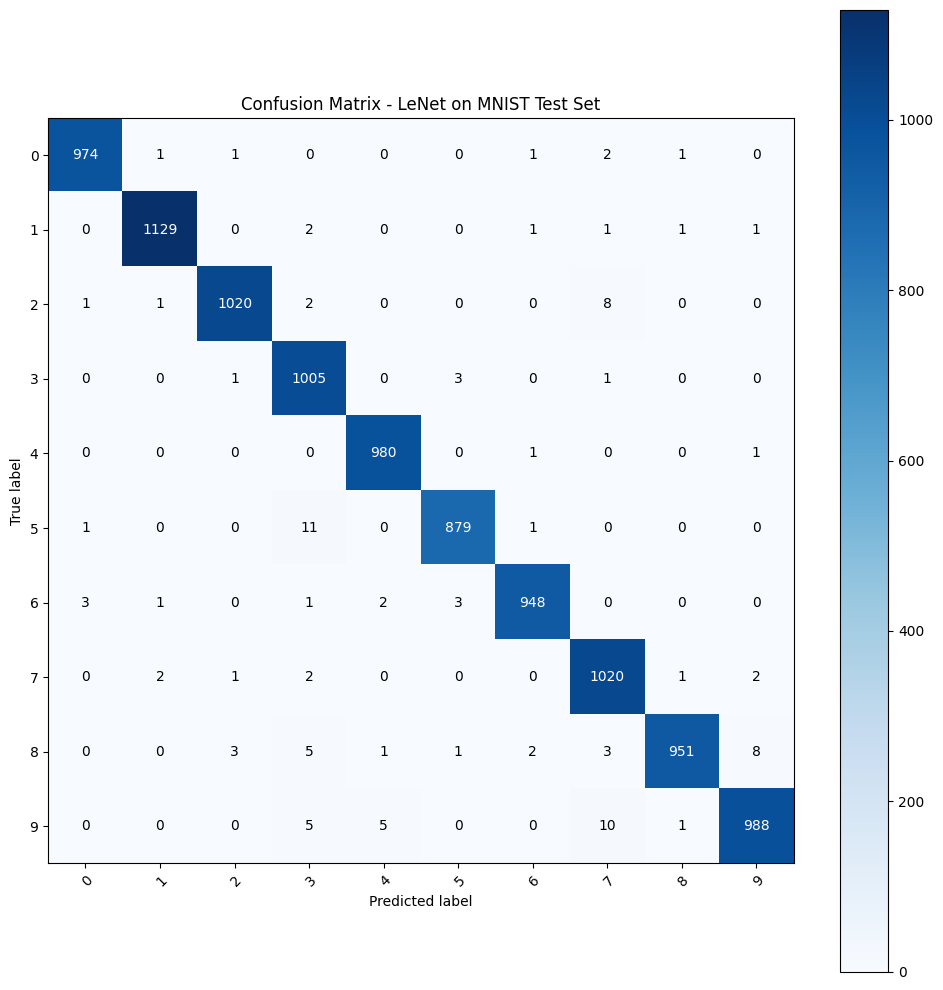

Normalized confusion matrix


<Figure size 1000x1000 with 0 Axes>

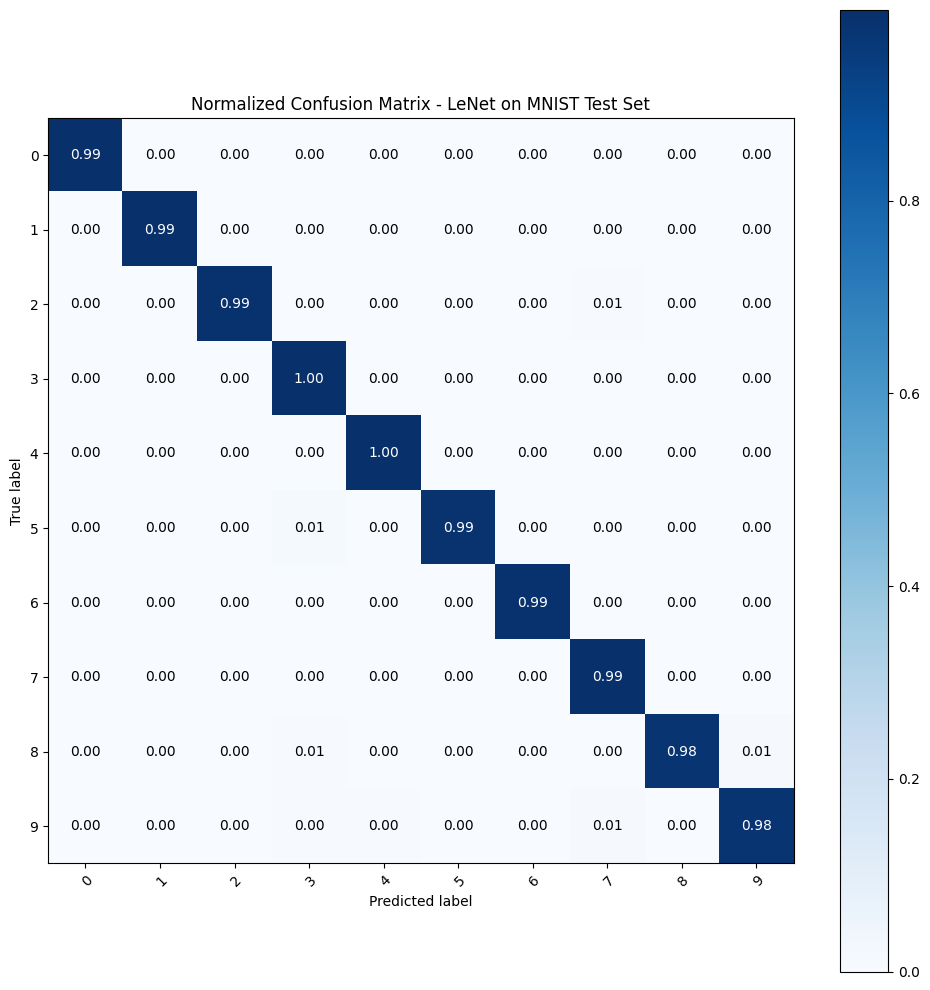

Accuracy for digit 0: 0.9939
Accuracy for digit 1: 0.9947
Accuracy for digit 2: 0.9884
Accuracy for digit 3: 0.9950
Accuracy for digit 4: 0.9980
Accuracy for digit 5: 0.9854
Accuracy for digit 6: 0.9896
Accuracy for digit 7: 0.9922
Accuracy for digit 8: 0.9764
Accuracy for digit 9: 0.9792


In [47]:
# Generate confusion matrices for the model
print("\nGenerating confusion matrices for test data...")

# Get predictions for test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert to numpy arrays
y_pred = np.array(all_preds)
y_true = np.array(all_targets)

# Define class names for MNIST (0-9)
class_names = [str(i) for i in range(10)]

# Plot standard confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(y_true, y_pred, classes=class_names, 
                    title='Confusion Matrix - LeNet on MNIST Test Set')
plt.savefig('lenet_confusion_matrix.png')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                    title='Normalized Confusion Matrix - LeNet on MNIST Test Set')
plt.savefig('lenet_normalized_confusion_matrix.png')
plt.show()

# Calculate per-class accuracy
cm = confusion_matrix(y_true, y_pred)
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for digit {i}: {acc:.4f}")
